<a href="https://colab.research.google.com/github/N3wBaz/MLzoomcamp/blob/main/hw4/homework_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold

In [84]:
df = pd.read_csv('AER_credit_card_data.csv')

In [85]:
df

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1314,yes,0,33.58333,4.5660,0.002146,7.333333,yes,no,0,94,1,19
1315,no,5,23.91667,3.1920,0.000376,0.000000,no,no,3,12,1,5
1316,yes,0,40.58333,4.6000,0.026513,101.298300,yes,no,2,1,1,2
1317,yes,0,32.83333,3.7000,0.008999,26.996670,no,yes,0,60,1,7


In [86]:
df['target'] = df['card'].apply(lambda x: 1 if x=='yes' else 0)

In [87]:
df['target']

0       1
1       1
2       1
3       1
4       1
       ..
1314    1
1315    0
1316    1
1317    1
1318    1
Name: target, Length: 1319, dtype: int64

In [88]:
df_train, df_val = train_test_split(df, test_size=0.4, random_state=1)
df_val, df_test = train_test_split(df_val, test_size=0.5, random_state=1)

y_train = df_train['target']
y_val = df_val['target']
y_test = df_test['target']

del df_train['target']
del df_val['target']
del df_test['target']

del df_train['card']
del df_val['card']
del df_test['card']

In [89]:
df_train.shape

(791, 11)

## Q1

In [90]:
from sklearn.metrics import auc

In [91]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    t = y_pred.mean()/2

    for t in range(len(y_val)):
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    
    return df_scores
    # return auc(df_scores['fpr'], df_scores['tpr'])



numerical = ['reports', 'dependents', 'active', 'share']
for i in numerical:
    # print(roc_auc_score(df_train[i] < df_train[i].mean(), y_train))
    tpr_fpr = tpr_fpr_dataframe(y_train, df_train[i])
    score = auc(tpr_fpr['fpr'], tpr_fpr['tpr'])
    if score < 0.5:
        score = 1 - score
    print(f"AUC {i}  :  {score}")


AUC reports  :  0.7019859488035615
AUC dependents  :  0.522894059543684
AUC active  :  0.6002017250973846
AUC share  :  0.5


## Q2

In [92]:
features = ["reports", "age", "income", "share", "expenditure", "dependents", "months",
            "majorcards", "active", "owner", "selfemp"]

train_dict = df_train[features].to_dict(orient='records')

dv = DictVectorizer(sparse=True)
dv.fit(train_dict)

X_train = dv.transform(train_dict)
# df_train[features]

In [93]:
model = LogisticRegression(solver='liblinear', C=1.0, random_state=1, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=1, solver='liblinear')

In [94]:
val_dict = df_val[features].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

In [95]:
# roc_auc_score(y_pred >= 0.5, y_val)
tpr_fpr = tpr_fpr_dataframe(y_val, y_pred)
score = auc(tpr_fpr['fpr'], tpr_fpr['tpr'])
score

0.9285714285714286

## Q3

In [96]:
thresholds = np.arange(0, 1, 0.01)

In [97]:
thresholds

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

In [98]:

# prec = []
# reca = []
# for threshold in thresholds:
#     true_positive = ((y_pred >= threshold) & (y_val == 1)).sum()
#     false_positive = ((y_pred >= threshold) & (y_val == 0)).sum()
#     false_negative = ((y_pred < threshold) & (y_val == 1)).sum()
#     true_negative = ((y_pred < threshold) & (y_val == 0)).sum()
#     precision = true_positive / (true_positive + false_positive)
#     recall = true_positive / (true_positive + false_negative)
#     prec.append(precision)
#     reca.append(recall)
# #     for_valid['threshold'] = threshold
# #     for_valid['precision'] = precision
# #     for_valid['recall'] = recall

# for_valid = pd.DataFrame({'threshold': thresholds, 'precision':prec, 'recall':reca})

#     for_valid[]
#     print(precision, recall)

def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['precision'] = df_scores.tp / (df_scores.fp + df_scores.tp)

    #     precision = true_positive / (true_positive + false_positive)
#     recall = true_positive / (true_positive + false_negative)
    
    return df_scores
plot_score = tpr_fpr_dataframe(y_val, y_pred)


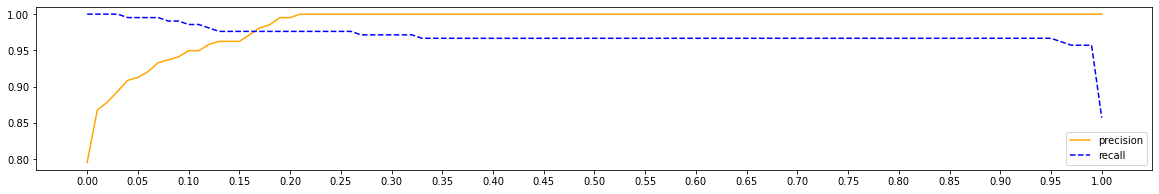

In [99]:
plt.figure(figsize=(20, 3))

# plt.plot(for_valid['threshold'], for_valid['precision'], color='orange', linestyle='solid', label='precision')
# plt.plot(for_valid['threshold'], for_valid['recall'], color='blue', linestyle='dashed', label='recall')
plt.plot(plot_score['threshold'], plot_score['precision'], color='orange', linestyle='solid', label='precision')
plt.plot(plot_score['threshold'], plot_score['recall'], color='blue', linestyle='dashed', label='recall')
plt.xticks(np.linspace(0, 1, 21))
# plt.grid(1,np.linspace(0, 1, 10))
plt.legend()

## Q4

In [100]:
# f1 = []
# for p,r in zip(prec, reca):
#     f1.append(2 * p * r /(p + r))
for_valid['f1'] = 2 * for_valid['precision'] * for_valid['recall'] / (for_valid['precision'] + for_valid['recall'])

In [101]:
for_valid

,threshold,precision,recall,f1
0,0.00,0.795455,1.000000,0.886076
1,0.01,0.867769,1.000000,0.929204
2,0.02,0.878661,1.000000,0.935412
3,0.03,0.893617,1.000000,0.943820
4,0.04,0.908696,0.995238,0.950000
...,...,...,...,...
95,0.95,1.000000,0.966667,0.983051
96,0.96,1.000000,0.961905,0.980583
97,0.97,1.000000,0.957143,0.978102
98,0.98,1.000000,0.957143,0.978102


In [102]:
for_valid['f1'].argmax()

21

In [103]:
for_valid.iloc[for_valid['f1'].argmax()]

threshold    0.210000
precision    1.000000
recall       0.976190
f1           0.987952
Name: 21, dtype: float64

## Q5


In [104]:
# df_train, df_val = train_test_split(df, test_size=0.4, random_state=1)
df_train_full = df
y_train_full = df_train_full['card']
# del df_train_full['target']
# del df_train_full['card']

In [105]:
# df_train_full

In [107]:
def train(df, y):
    cat = df[features].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear')
    model.fit(X, y)

    return dv, model


def predict(df, dv, model):
    cat = df[features].to_dict(orient='records')
    
    X = dv.transform(cat)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred


aucs = []
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    y_train = df_train.target.values

    df_val = df_train_full.iloc[val_idx]
    y_val = df_val.target.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    rocauc = roc_auc_score(y_val, y_pred)
    aucs.append(rocauc)

In [108]:
np.array(aucs).std()

0.0015474755482891552

## Q6

In [109]:
def train(df, y, C=1.0):
    cat = df[features].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X, y)

    return dv, model

In [110]:
for C in [0.01, 0.1, 1, 10]:
    aucs = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.target.values
        y_val = df_val.target.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))

C=0.01, auc = 0.993 ± 0.004
C=0.1, auc = 0.995 ± 0.002
C=1, auc = 0.996 ± 0.002
C=10, auc = 0.996 ± 0.001
